# Proyecto BBVA y Santander

## Importar librerías

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## DESCARGA DE DATOS

In [4]:
# Definir los símbolos de las acciones
bbva_ticker = "BBVA.MC"   # BBVA (Bolsa de Madrid)
santander_ticker = "SAN.MC"  # Banco Santander (Bolsa de Madrid)

# Definir el rango de fechas
start_date = "2000-01-01"
end_date   = "2025-10-31"

# Descargar los datos históricos desde Yahoo Finance
bbva_data = yf.download(bbva_ticker, start=start_date, end=end_date)
santander_data = yf.download(santander_ticker, start=start_date, end=end_date)

# Mostrar resumen por consola
print("BBVA data:")
print(bbva_data.head())
print("\nSantander data:")
print(santander_data.head())

# Guardar los datos en CSV
bbva_data.to_csv("csv/bbva_data.csv")
santander_data.to_csv("csv/santander_data.csv")


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14740\3105922251.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bbva_data = yf.download(bbva_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14740\3105922251.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  santander_data = yf.download(santander_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


BBVA data:
Price          Close      High       Low      Open    Volume
Ticker       BBVA.MC   BBVA.MC   BBVA.MC   BBVA.MC   BBVA.MC
Date                                                        
2000-01-03  4.115110  4.155739  4.106404  4.135425   8244257
2000-01-04  4.007734  4.088992  3.993224  4.062873   8522096
2000-01-05  3.917771  3.990322  3.900359  3.970008  12159826
2000-01-06  3.917771  3.917771  3.917771  3.917771         0
2000-01-07  3.967107  4.001931  3.926478  4.001931  62261944

Santander data:
Price          Close      High       Low      Open   Volume
Ticker        SAN.MC    SAN.MC    SAN.MC    SAN.MC   SAN.MC
Date                                                       
2000-01-03  2.625066  2.661974  2.595078  2.652747  8797337
2000-01-04  2.562785  2.606613  2.539717  2.592772  8811013
2000-01-05  2.500503  2.546637  2.479742  2.514343  9333517
2000-01-06  2.500503  2.500503  2.500503  2.500503        0
2000-01-07  2.611226  2.618146  2.516650  2.518957  9603132


In [5]:
# 1. leer normal (una sola cabecera)
df = pd.read_csv("csv/bbva_data.csv")

# 2. eliminar las filas “raras” (las 2 primeras)
df = df[~df["Price"].isin(["Ticker", "Date"])].copy()

# 3. renombrar la primera columna porque en realidad es la fecha
df = df.rename(columns={"Price": "Date"})

# 4. convertir la fecha
df["Date"] = pd.to_datetime(df["Date"])

# 5. convertir el resto a numérico
for col in ["Close", "High", "Low", "Open", "Volume"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")


# Para ser coherentes con lo anterior, creamos una columna PRICE fija:
df["Price"] = pd.to_numeric(df["Close"], errors="coerce")

# ordenar por fecha
df = df.sort_values("Date").reset_index(drop=True)

print(df.head())
print(df.dtypes)



        Date     Close      High       Low      Open    Volume     Price
0 2000-01-03  4.115110  4.155739  4.106404  4.135425   8244257  4.115110
1 2000-01-04  4.007734  4.088992  3.993224  4.062873   8522096  4.007734
2 2000-01-05  3.917771  3.990322  3.900359  3.970008  12159826  3.917771
3 2000-01-06  3.917771  3.917771  3.917771  3.917771         0  3.917771
4 2000-01-07  3.967107  4.001931  3.926478  4.001931  62261944  3.967107
Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
Price            float64
dtype: object


## PREPROCESAMIENTO

In [6]:
def preparar_datos_desde_df(df, col_target="Price", window_size=30):
    df = df.sort_values("Date").reset_index(drop=True)

    if col_target not in df.columns:
        raise ValueError(f"No encuentro la columna {col_target}. Tengo: {df.columns.tolist()}")

    valores = df[[col_target]].values.astype(float)

    scaler = MinMaxScaler(feature_range=(0, 1))
    valores_scaled = scaler.fit_transform(valores)

    X, y = [], []
    for i in range(window_size, len(valores_scaled)):
        X.append(valores_scaled[i-window_size:i, 0])
        y.append(valores_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y, scaler, df

window_size = 30
X_bbva, y_bbva, scaler_bbva, bbva_df = preparar_datos_desde_df(df, col_target="Price", window_size=window_size)

print("X_bbva:", X_bbva.shape)
print("y_bbva:", y_bbva.shape)



X_bbva: (6604, 30, 1)
y_bbva: (6604,)


## Train y test temporal

In [7]:
# 80% train, 20% test (temporal, sin shuffle)
train_size = int(len(X_bbva) * 0.8)
X_train, X_test = X_bbva[:train_size], X_bbva[train_size:]
y_train, y_test = y_bbva[:train_size], y_bbva[train_size:]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (5283, 30, 1) (5283,)
Test : (1321, 30, 1) (1321,)


## Modelos

In [8]:
input_shape = (window_size, 1)

def build_rnn():
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_lstm():
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_gru():
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


## Entrenamiento

In [9]:
EPOCHS = 1000
BATCH = 32

# Callbacks comunes
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=80,             # se detiene si 80 epochs sin mejorar
    restore_best_weights=True
)

def entrenar_modelo(nombre, build_fn, X_train, y_train, X_test, y_test):
    """
    Entrena un modelo (RNN, LSTM o GRU) con EarlyStopping y ModelCheckpoint
    """
    print(f"\nEntrenando modelo {nombre}...\n")
    model = build_fn()
    checkpoint = ModelCheckpoint(
        f"mejor_{nombre.lower()}_bbva.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, y_test),
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    return model, history

# ==============================
# ENTRENAR LOS TRES
# ==============================

rnn_model,  hist_rnn  = entrenar_modelo("RNN",  build_rnn,  X_train, y_train, X_test, y_test)
lstm_model, hist_lstm = entrenar_modelo("LSTM", build_lstm, X_train, y_train, X_test, y_test)
gru_model,  hist_gru  = entrenar_modelo("GRU",  build_gru,  X_train, y_train, X_test, y_test)



Entrenando modelo RNN...

Epoch 1/1000


c:\Users\Usuario\OneDrive\Documentos\GitHub\Aprendizaje_Automatico\env11\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 1: val_loss improved from None to 0.00368, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.1241e-04 - val_loss: 0.0037
Epoch 2/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7412e-05
Epoch 2: val_loss improved from 0.00368 to 0.00239, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.4252e-05 - val_loss: 0.0024
Epoch 3/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1645e-05
Epoch 3: val_loss improved from 0.00239 to 0.00129, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9651e-05 - val_loss: 0.0013
Epoch 4/1000
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2634e-05
Epoch 4: val_loss improved from 0.00129 to 0.00059, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9821e-05 - val_loss: 5.9194e-04
Epoch 5/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3652e-05
Epoch 5: val_loss improved from 0.00059 to 0.00052, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1452e-05 - val_loss: 5.1680e-04
Epoch 6/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5521e-05
Epoch 6: val_loss did not improve from 0.00052
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3558e-05 - val_loss: 6.4184e-04
Epoch 7/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8495e-05
Epoch 7: val_loss did not improve from 0.00052
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.0736e-05 - val_loss: 5.3826e-04
Epoch 8/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4777e-05
Epoch 8: val_loss improved from 0.00052 to 0.00029, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5670e-05 - val_loss: 2.9264e-04
Epoch 9/1000
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7926e-05
Epoch 9: val_loss did not improve from 0.00029
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6626e-05 - val_loss: 3.1917e-04
Epoch 10/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3425e-05
Epoch 10: val_loss improved from 0.00029 to 0.00027, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3442e-05 - val_loss: 2.6622e-04
Epoch 11/1000
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3225e-05
Epoch 11: val_loss did not improve from 0.00027
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4163e-05 - val_loss: 3.6427e-04
Epoch 12/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7559e-05
Epoch 12: val_loss did not improve from 0.00027
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5301e-05 - val_loss: 3.1376e-04
Epoch 13/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3435e-05
Epoch 13: val_loss improved from 0.00027 to 0.00021, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6230e-05 - val_loss: 2.0926e-04
Epoch 14/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0308e-05
Epoch 14: val_loss improved from 0.00021 to 0.00018, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0399e-05 - val_loss: 1.8041e-04
Epoch 15/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0711e-05
Epoch 15: val_loss did not improve from 0.00018
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0162e-05 - val_loss: 2.8247e-04
Epoch 16/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0165e-05
Epoch 16: val_loss improved from 0.00018 to 0.00016, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9241e-05 - val_loss: 1.6347e-04
Epoch 17/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8051e-05
Epoch 17: val_loss improved from 0.00016 to 0.00014, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1363e-05 - val_loss: 1.4081e-04
Epoch 18/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9005e-05
Epoch 18: val_loss improved from 0.00014 to 0.00013, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9725e-05 - val_loss: 1.3039e-04
Epoch 19/1000
154/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9531e-05
Epoch 19: val_loss did not improve from 0.00013
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0500e-05 - val_loss: 3.1125e-04
Epoch 20/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4441e-05
Epoch 20: val_loss did not improve from 0.00013
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1503e-05 - val_loss: 2.1540e-04
Epoch 21/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9447e-05
Epoch 21: val_loss did not improve from 0.00013
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9223e-05 - val_loss: 2.0178e-04
Epoch 22/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1348e-05
Epoch 22: val_loss did not improve from 0.00013
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8963e-05 - val_loss: 1.5830e-04
Epoch 23/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9300e-05
Epoch 23: val_loss impr

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9303e-05 - val_loss: 1.1743e-04
Epoch 24/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8350e-05
Epoch 24: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7681e-05 - val_loss: 1.6423e-04
Epoch 25/1000
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0198e-05
Epoch 25: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8934e-05 - val_loss: 1.4314e-04
Epoch 26/1000
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0709e-05
Epoch 26: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2102e-05 - val_loss: 1.6833e-04
Epoch 27/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8614e-05
Epoch 27: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9080e-05 - val_loss: 2.3888e-04
Epoch 28/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7340e-05
Epoch 28: val_loss impr

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8436e-05 - val_loss: 1.0050e-04
Epoch 29/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1161e-05
Epoch 29: val_loss improved from 0.00010 to 0.00009, saving model to mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9227e-05 - val_loss: 9.0785e-05
Epoch 30/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9808e-05
Epoch 30: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8964e-05 - val_loss: 1.1205e-04
Epoch 31/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6056e-05
Epoch 31: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7760e-05 - val_loss: 9.3578e-05
Epoch 32/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8759e-05
Epoch 32: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8790e-05 - val_loss: 1.6726e-04
Epoch 33/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9285e-05
Epoch 33: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9205e-05 - val_loss: 1.3279e-04
Epoch 34/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9998e-05
Epoch 34: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9082e-05 - val_loss: 9.0747e-05
Epoch 44/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9774e-05
Epoch 44: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0050e-05 - val_loss: 9.2360e-05
Epoch 45/1000
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7337e-05
Epoch 45: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7499e-05 - val_loss: 1.5993e-04
Epoch 46/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8741e-05
Epoch 46: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9915e-05 - val_loss: 1.7603e-04
Epoch 47/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0359e-05
Epoch 47: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8981e-05 - val_loss: 1.5333e-04
Epoch 48/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7680e-05
Epoch 48: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9261e-05 - val_loss: 8.7958e-05
Epoch 50/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9089e-05
Epoch 50: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0045e-05 - val_loss: 9.4323e-05
Epoch 51/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7973e-05
Epoch 51: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8425e-05 - val_loss: 1.1727e-04
Epoch 52/1000
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9738e-05
Epoch 52: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8063e-05 - val_loss: 1.1606e-04
Epoch 53/1000
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8073e-05
Epoch 53: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7938e-05 - val_loss: 9.5892e-05
Epoch 54/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8364e-05
Epoch 54: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 9.2012e-04 - val_loss: 9.0574e-04
Epoch 2/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0350e-04
Epoch 2: val_loss did not improve from 0.00091
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0215e-04 - val_loss: 0.0012
Epoch 3/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.7900e-05
Epoch 3: val_loss improved from 0.00091 to 0.00036, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9.3863e-05 - val_loss: 3.6041e-04
Epoch 4/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4877e-05
Epoch 4: val_loss did not improve from 0.00036
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.5510e-05 - val_loss: 4.7482e-04
Epoch 5/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6396e-05
Epoch 5: val_loss improved from 0.00036 to 0.00030, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 7.7975e-05 - val_loss: 3.0020e-04
Epoch 6/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.3551e-05
Epoch 6: val_loss improved from 0.00030 to 0.00021, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.2114e-05 - val_loss: 2.1409e-04
Epoch 7/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9102e-05
Epoch 7: val_loss did not improve from 0.00021
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.8367e-05 - val_loss: 2.2746e-04
Epoch 8/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5116e-05
Epoch 8: val_loss improved from 0.00021 to 0.00018, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.4021e-05 - val_loss: 1.7666e-04
Epoch 9/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3503e-05
Epoch 9: val_loss did not improve from 0.00018
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.3344e-05 - val_loss: 1.8320e-04
Epoch 10/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3061e-05
Epoch 10: val_loss improved from 0.00018 to 0.00016, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.7910e-05 - val_loss: 1.5912e-04
Epoch 11/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6091e-05
Epoch 11: val_loss improved from 0.00016 to 0.00016, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.4835e-05 - val_loss: 1.5757e-04
Epoch 12/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3986e-05
Epoch 12: val_loss improved from 0.00016 to 0.00014, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.2927e-05 - val_loss: 1.3794e-04
Epoch 13/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2298e-05
Epoch 13: val_loss improved from 0.00014 to 0.00013, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.1985e-05 - val_loss: 1.3396e-04
Epoch 14/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1873e-05
Epoch 14: val_loss improved from 0.00013 to 0.00013, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.0057e-05 - val_loss: 1.2851e-04
Epoch 15/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4821e-05
Epoch 15: val_loss improved from 0.00013 to 0.00012, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.5587e-05 - val_loss: 1.2078e-04
Epoch 16/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4658e-05
Epoch 16: val_loss improved from 0.00012 to 0.00011, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.3995e-05 - val_loss: 1.1409e-04
Epoch 17/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9271e-05
Epoch 17: val_loss improved from 0.00011 to 0.00011, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.3825e-05 - val_loss: 1.0793e-04
Epoch 18/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0284e-05
Epoch 18: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.9956e-05 - val_loss: 1.0811e-04
Epoch 19/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9985e-05
Epoch 19: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.1521e-05 - val_loss: 1.1158e-04
Epoch 20/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3452e-05
Epoch 20: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.0069e-05 - val_loss: 1.1107e-04
Epoch 21/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7930e-05
Epoch 21: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.5547e-05 - val_loss: 1.1254e-04
Epoch 22/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6518e-05
Epoch 22: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.4577e-05 - val_loss: 9.7766e-05
Epoch 23/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5770e-05
Epoch 23: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.4131e-05 - val_loss: 9.8001e-05
Epoch 24/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1938e-05
Epoch 24: val_loss improved from 0.00010 to 0.00009, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.2641e-05 - val_loss: 8.8898e-05
Epoch 25/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0095e-05
Epoch 25: val_loss improved from 0.00009 to 0.00009, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.2565e-05 - val_loss: 8.7909e-05
Epoch 26/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1383e-05
Epoch 26: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1248e-05 - val_loss: 1.0573e-04
Epoch 27/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0089e-05
Epoch 27: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1812e-05 - val_loss: 1.0812e-04
Epoch 28/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2977e-05
Epoch 28: val_loss improved from 0.00009 to 0.00008, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1166e-05 - val_loss: 8.4157e-05
Epoch 29/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3563e-05
Epoch 29: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.0080e-05 - val_loss: 9.1304e-05
Epoch 30/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1134e-05
Epoch 30: val_loss improved from 0.00008 to 0.00008, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.9832e-05 - val_loss: 8.2690e-05
Epoch 31/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8745e-05
Epoch 31: val_loss improved from 0.00008 to 0.00008, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9605e-05 - val_loss: 8.2561e-05
Epoch 32/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8056e-05
Epoch 32: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9185e-05 - val_loss: 8.4627e-05
Epoch 33/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1602e-05
Epoch 33: val_loss improved from 0.00008 to 0.00008, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.8334e-05 - val_loss: 8.2273e-05
Epoch 34/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8207e-05
Epoch 34: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.8155e-05 - val_loss: 1.0569e-04
Epoch 35/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8566e-05
Epoch 35: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.8119e-05 - val_loss: 9.7845e-05
Epoch 36/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9034e-05
Epoch 36: val_loss improved from 0.00008 to 0.00008, saving model to mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7312e-05 - val_loss: 8.2087e-05
Epoch 37/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9401e-05
Epoch 37: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.8525e-05 - val_loss: 1.0780e-04
Epoch 38/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9870e-05
Epoch 38: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.8864e-05 - val_loss: 8.6215e-05
Epoch 39/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8919e-05
Epoch 39: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9180e-05 - val_loss: 9.3535e-05
Epoch 40/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8687e-05
Epoch 40: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8334e-05 - val_loss: 9.8965e-05
Epoch 41/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9075e-05
Epoch 41: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0014 - val_loss: 2.2147e-04
Epoch 2/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.1982e-05
Epoch 2: val_loss improved from 0.00022 to 0.00020, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.0793e-05 - val_loss: 1.9877e-04
Epoch 3/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.6272e-05
Epoch 3: val_loss improved from 0.00020 to 0.00016, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 5.5072e-05 - val_loss: 1.5664e-04
Epoch 4/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1745e-05
Epoch 4: val_loss did not improve from 0.00016
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.9721e-05 - val_loss: 1.6083e-04
Epoch 5/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0267e-05
Epoch 5: val_loss improved from 0.00016 to 0.00013, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.6062e-05 - val_loss: 1.2806e-04
Epoch 6/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.3930e-05
Epoch 6: val_loss improved from 0.00013 to 0.00012, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.3998e-05 - val_loss: 1.1975e-04
Epoch 7/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.3397e-05
Epoch 7: val_loss improved from 0.00012 to 0.00012, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.2004e-05 - val_loss: 1.1703e-04
Epoch 8/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9012e-05
Epoch 8: val_loss improved from 0.00012 to 0.00011, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.9391e-05 - val_loss: 1.0727e-04
Epoch 9/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9013e-05
Epoch 9: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.7791e-05 - val_loss: 1.6597e-04
Epoch 10/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.6859e-05
Epoch 10: val_loss improved from 0.00011 to 0.00010, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.7492e-05 - val_loss: 1.0443e-04
Epoch 11/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7489e-05
Epoch 11: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.6097e-05 - val_loss: 1.2735e-04
Epoch 12/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4987e-05
Epoch 12: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.3846e-05 - val_loss: 1.0892e-04
Epoch 13/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1973e-05
Epoch 13: val_loss improved from 0.00010 to 0.00010, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.3015e-05 - val_loss: 1.0162e-04
Epoch 14/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.3772e-05
Epoch 14: val_loss improved from 0.00010 to 0.00010, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.4064e-05 - val_loss: 9.8470e-05
Epoch 15/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0567e-05
Epoch 15: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.0992e-05 - val_loss: 1.1765e-04
Epoch 16/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1389e-05
Epoch 16: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.2390e-05 - val_loss: 1.8194e-04
Epoch 17/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.2049e-05
Epoch 17: val_loss improved from 0.00010 to 0.00010, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.3380e-05 - val_loss: 9.7903e-05
Epoch 18/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1335e-05
Epoch 18: val_loss improved from 0.00010 to 0.00009, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.1773e-05 - val_loss: 8.6507e-05
Epoch 19/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1119e-05
Epoch 19: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.0488e-05 - val_loss: 1.0822e-04
Epoch 20/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2383e-05
Epoch 20: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.0212e-05 - val_loss: 1.1926e-04
Epoch 21/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.2282e-05
Epoch 21: val_loss improved from 0.00009 to 0.00009, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.1237e-05 - val_loss: 8.6166e-05
Epoch 22/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8189e-05
Epoch 22: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.9064e-05 - val_loss: 1.1078e-04
Epoch 23/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0012e-05
Epoch 23: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.8716e-05 - val_loss: 9.6242e-05
Epoch 24/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5493e-05
Epoch 24: val_loss improved from 0.00009 to 0.00008, saving model to mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.1333e-05 - val_loss: 8.2325e-05
Epoch 25/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9307e-05
Epoch 25: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.9246e-05 - val_loss: 8.6424e-05
Epoch 26/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9491e-05
Epoch 26: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.9596e-05 - val_loss: 8.8322e-05
Epoch 27/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1332e-05
Epoch 27: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.1514e-05 - val_loss: 9.2443e-05
Epoch 28/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1408e-05
Epoch 28: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.8799e-05 - val_loss: 8.3686e-05
Epoch 29/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8488e-05
Epoch 29: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.7533e-05 - val_loss: 8.1439e-05
Epoch 38/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9516e-05
Epoch 38: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.8007e-05 - val_loss: 8.4110e-05
Epoch 39/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7835e-05
Epoch 39: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.9223e-05 - val_loss: 8.1799e-05
Epoch 40/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9023e-05
Epoch 40: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.7554e-05 - val_loss: 8.3963e-05
Epoch 41/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8284e-05
Epoch 41: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7599e-05 - val_loss: 8.4254e-05
Epoch 42/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0161e-05
Epoch 42: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.6865e-05 - val_loss: 8.1188e-05
Epoch 70/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9936e-05
Epoch 70: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.8734e-05 - val_loss: 9.1161e-05
Epoch 71/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6966e-05
Epoch 71: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7514e-05 - val_loss: 8.3038e-05
Epoch 72/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8179e-05
Epoch 72: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.8524e-05 - val_loss: 1.0369e-04
Epoch 73/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9346e-05
Epoch 73: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.8426e-05 - val_loss: 8.1764e-05
Epoch 74/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9816e-05
Epoch 74: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7464e-05 - val_loss: 8.1179e-05
Epoch 80/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3814e-05
Epoch 80: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9012e-05 - val_loss: 9.2741e-05
Epoch 81/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9601e-05
Epoch 81: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.8071e-05 - val_loss: 1.0048e-04
Epoch 82/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8762e-05
Epoch 82: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.7526e-05 - val_loss: 8.3710e-05
Epoch 83/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7993e-05
Epoch 83: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.7946e-05 - val_loss: 9.7675e-05
Epoch 84/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9268e-05
Epoch 84: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.8380e-05 - val_loss: 8.0992e-05
Epoch 86/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7647e-05
Epoch 86: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.7513e-05 - val_loss: 9.1568e-05
Epoch 87/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7362e-05
Epoch 87: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.7670e-05 - val_loss: 8.5627e-05
Epoch 88/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5971e-05
Epoch 88: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.6798e-05 - val_loss: 1.0502e-04
Epoch 89/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7919e-05
Epoch 89: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.7223e-05 - val_loss: 9.1137e-05
Epoch 90/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8155e-05
Epoch 90: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.6738e-05 - val_loss: 8.0801e-05
Epoch 91/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8370e-05
Epoch 91: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.7139e-05 - val_loss: 8.0840e-05
Epoch 92/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7526e-05
Epoch 92: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.7606e-05 - val_loss: 1.0230e-04
Epoch 93/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6867e-05
Epoch 93: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7283e-05 - val_loss: 9.8208e-05
Epoch 94/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.7718e-05
Epoch 94: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7728e-05 - val_loss: 8.6054e-05
Epoch 95/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.6832e-05
Epoch 95: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7823e-05 - val_loss: 8.0785e-05
Epoch 120/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7486e-05
Epoch 120: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.7039e-05 - val_loss: 8.2496e-05
Epoch 121/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5710e-05
Epoch 121: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7155e-05 - val_loss: 9.8079e-05
Epoch 122/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6498e-05
Epoch 122: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9574e-05 - val_loss: 8.6584e-05
Epoch 123/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6293e-05
Epoch 123: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.6986e-05 - val_loss: 8.2092e-05
Epoch 124/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6224e-05
Epoc

In [10]:
# todas con la misma forma de entrada
input_shape = (window_size, 1)

def build_rnn():
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_lstm():
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_gru():
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## Predicciones

In [11]:
# predicciones (en escala 0-1)
y_pred_rnn  = rnn_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru  = gru_model.predict(X_test)

# desescalar
y_test_real = scaler_bbva.inverse_transform(y_test.reshape(-1, 1))
pred_rnn_real  = scaler_bbva.inverse_transform(y_pred_rnn)
pred_lstm_real = scaler_bbva.inverse_transform(y_pred_lstm)
pred_gru_real  = scaler_bbva.inverse_transform(y_pred_gru)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


## Métricas

In [12]:
def evaluar(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

mae_rnn, rmse_rnn   = evaluar(y_test_real, pred_rnn_real)
mae_lstm, rmse_lstm = evaluar(y_test_real, pred_lstm_real)
mae_gru, rmse_gru   = evaluar(y_test_real, pred_gru_real)

print("RNN  -> MAE:", mae_rnn,  "RMSE:", rmse_rnn)
print("LSTM -> MAE:", mae_lstm, "RMSE:", rmse_lstm)
print("GRU  -> MAE:", mae_gru,  "RMSE:", rmse_gru)


RNN  -> MAE: 0.09703635194823199 RMSE: 0.14943247117886446
LSTM -> MAE: 0.09457839690402631 RMSE: 0.14435946580991768
GRU  -> MAE: 0.09353865709023253 RMSE: 0.14320930183212163


# Graficar

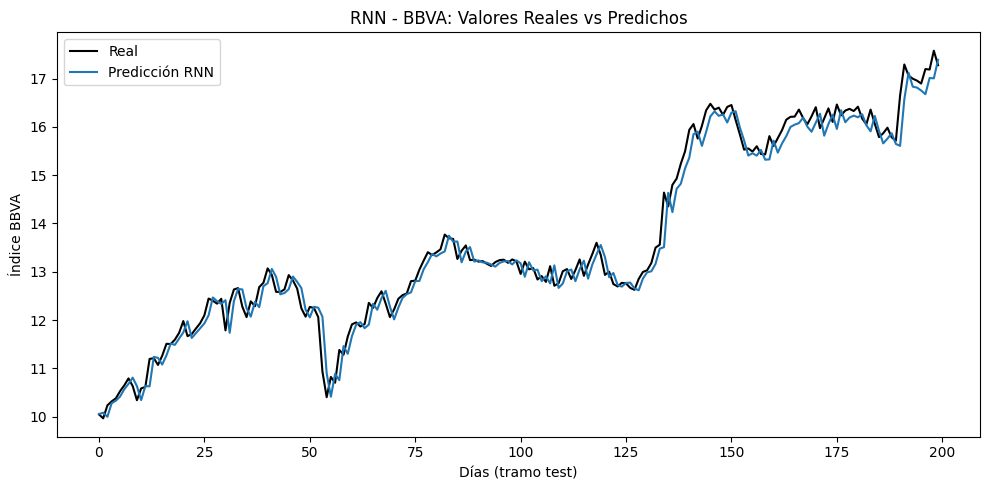

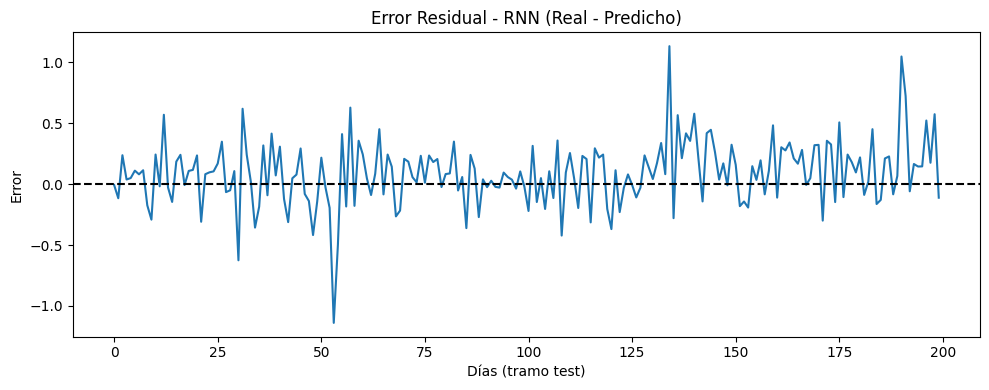

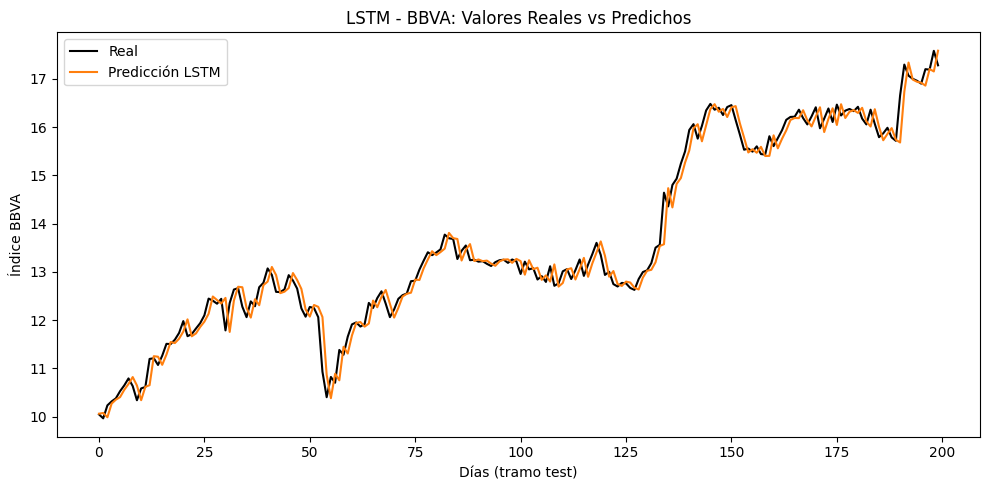

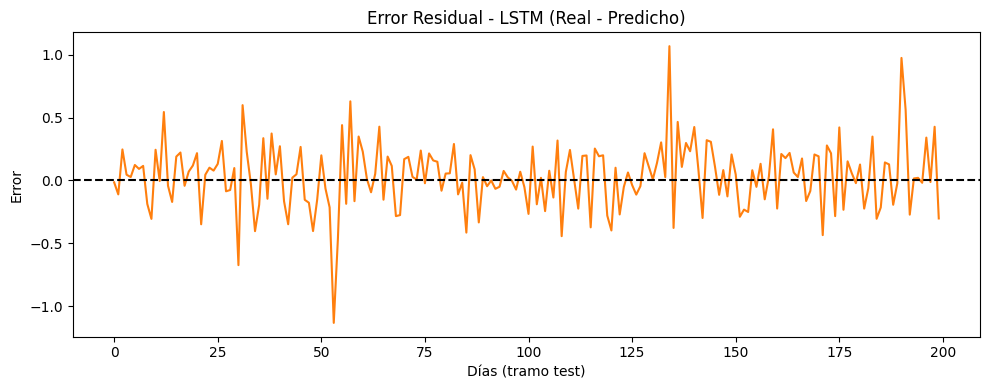

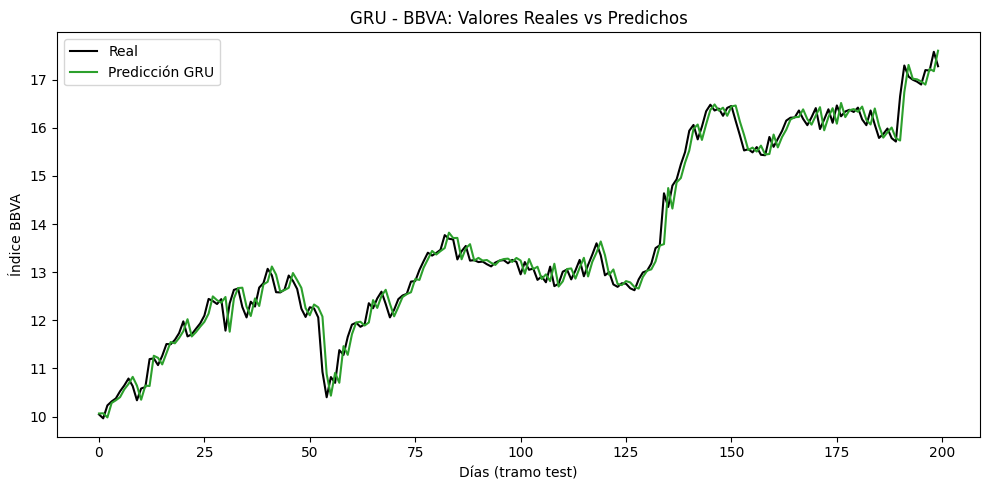

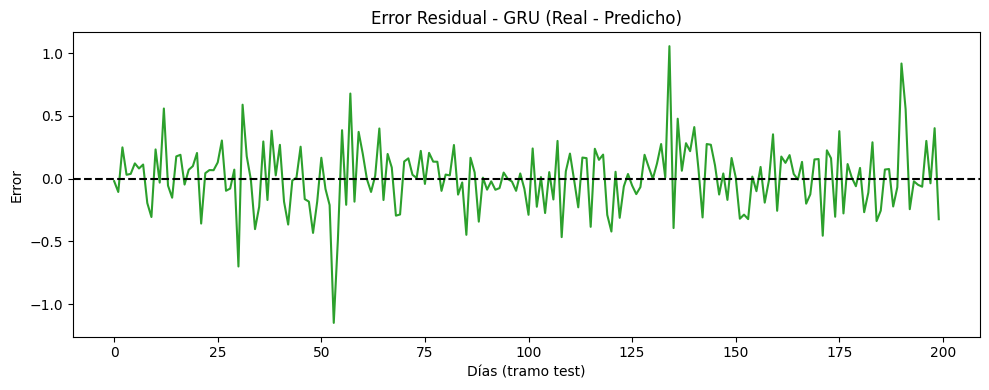

In [13]:
# --- Tramo a mostrar (últimos 200 días del test, por ejemplo) ---
n_mostrar = 200
y_real_plot = y_test_real[-n_mostrar:]
pred_rnn_plot  = pred_rnn_real[-n_mostrar:]
pred_lstm_plot = pred_lstm_real[-n_mostrar:]
pred_gru_plot  = pred_gru_real[-n_mostrar:]

# ===============================
# 1️⃣ RNN
# ===============================
plt.figure(figsize=(10,5))
plt.plot(y_real_plot, label="Real", color="black")
plt.plot(pred_rnn_plot, label="Predicción RNN", color="tab:blue")
plt.title("RNN - BBVA: Valores Reales vs Predichos")
plt.xlabel("Días (tramo test)")
plt.ylabel("Índice BBVA")
plt.legend()
plt.tight_layout()
plt.show()

# --- Error RNN ---
plt.figure(figsize=(10,4))
plt.plot(y_real_plot - pred_rnn_plot, color="tab:blue")
plt.axhline(0, color="black", linestyle="--")
plt.title("Error Residual - RNN (Real - Predicho)")
plt.xlabel("Días (tramo test)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

# ===============================
# 2️⃣ LSTM
# ===============================
plt.figure(figsize=(10,5))
plt.plot(y_real_plot, label="Real", color="black")
plt.plot(pred_lstm_plot, label="Predicción LSTM", color="tab:orange")
plt.title("LSTM - BBVA: Valores Reales vs Predichos")
plt.xlabel("Días (tramo test)")
plt.ylabel("Índice BBVA")
plt.legend()
plt.tight_layout()
plt.show()

# --- Error LSTM ---
plt.figure(figsize=(10,4))
plt.plot(y_real_plot - pred_lstm_plot, color="tab:orange")
plt.axhline(0, color="black", linestyle="--")
plt.title("Error Residual - LSTM (Real - Predicho)")
plt.xlabel("Días (tramo test)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

# ===============================
# 3️⃣ GRU
# ===============================
plt.figure(figsize=(10,5))
plt.plot(y_real_plot, label="Real", color="black")
plt.plot(pred_gru_plot, label="Predicción GRU", color="tab:green")
plt.title("GRU - BBVA: Valores Reales vs Predichos")
plt.xlabel("Días (tramo test)")
plt.ylabel("Índice BBVA")
plt.legend()
plt.tight_layout()
plt.show()

# --- Error GRU ---
plt.figure(figsize=(10,4))
plt.plot(y_real_plot - pred_gru_plot, color="tab:green")
plt.axhline(0, color="black", linestyle="--")
plt.title("Error Residual - GRU (Real - Predicho)")
plt.xlabel("Días (tramo test)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()


In [14]:
def predecir_siguiente(model, df_original, scaler, col_target="Price", window_size=30):
    # usamos el df limpio que tenías: bbva_df
    ultimos = df_original[[col_target]].values.astype(float)[-window_size:]
    ultimos_scaled = scaler.transform(ultimos)
    X_input = ultimos_scaled.reshape((1, window_size, 1))
    pred_scaled = model.predict(X_input)
    pred = scaler.inverse_transform(pred_scaled)
    return pred[0,0]

pred_manana_lstm = predecir_siguiente(lstm_model, bbva_df, scaler_bbva, col_target="Price", window_size=window_size)
print("Predicción BBVA próximo día (LSTM):", pred_manana_lstm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicción BBVA próximo día (LSTM): 17.19768


## Predecir dias futuros

In [15]:
def predecir_n_dias(model, df_original, scaler, col_target="Price", window_size=30, n_dias=7):
    # 1. cogemos los últimos window_size valores reales
    serie = df_original[[col_target]].values.astype(float)
    ultimos = serie[-window_size:]  # shape (30, 1)

    # los pasamos a escala
    ultimos_scaled = scaler.transform(ultimos)

    preds_desescaladas = []

    # trabajamos en una copia que iremos ampliando
    ventana_actual = ultimos_scaled.copy()  # shape (30,1)

    for _ in range(n_dias):
        # (1, pasos, 1)
        X_input = ventana_actual.reshape((1, window_size, 1))
        pred_scaled = model.predict(X_input, verbose=0)
        # desescalar
        pred_real = scaler.inverse_transform(pred_scaled)[0, 0]
        preds_desescaladas.append(pred_real)

        # ahora actualizamos la ventana: quitamos el 1º y metemos la predicción al final
        nuevo_valor_scaled = pred_scaled  # shape (1,1)
        ventana_actual = np.vstack([ventana_actual[1:], nuevo_valor_scaled])

    return preds_desescaladas

In [16]:
# última fecha real
ultima_fecha = bbva_df["Date"].max()

# generamos 7 fechas a partir de la última
fechas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1),
                               periods=7, freq="B")  # "B" para días hábiles

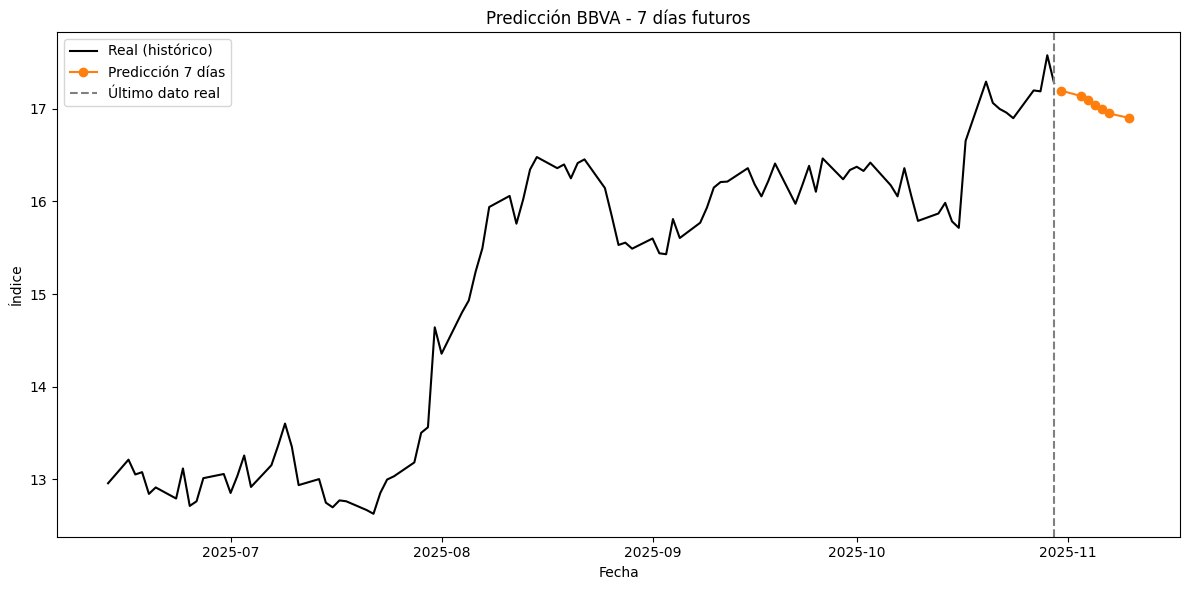

In [17]:
# 1) obtenemos las 7 predicciones
preds_7 = predecir_n_dias(lstm_model, bbva_df, scaler_bbva,
                          col_target="Price", window_size=window_size, n_dias=7)

# 2) hacemos un DataFrame de futuro
df_futuro = pd.DataFrame({
    "Date": fechas_futuras,
    "Predicted_Price": preds_7
})

# 3) para ver contexto, cogemos los últimos, por ejemplo, 100 días reales
historico_plot = bbva_df[["Date", "Price"]].tail(100).copy()

# 4) graficar
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# parte histórica
plt.plot(historico_plot["Date"], historico_plot["Price"], label="Real (histórico)", color="black")

# parte futura (solo predicción)
plt.plot(df_futuro["Date"], df_futuro["Predicted_Price"],
         label="Predicción 7 días", color="tab:orange", marker="o")

# marcar visualmente el corte
plt.axvline(historico_plot["Date"].max(), color="gray", linestyle="--", label="Último dato real")

plt.title("Predicción BBVA - 7 días futuros")
plt.xlabel("Fecha")
plt.ylabel("Índice")
plt.legend()
plt.tight_layout()
plt.show()
